# Import required packages

In [1]:
import os, re, gc, json, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from langdetect import detect, DetectorFactory
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest
from joblib import parallel_backend
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier 
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, precision_score, f1_score, recall_score
from sklearn import set_config


### Read Dataset

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction.

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.



In [2]:
curr_path = os.getcwd()
dataset_path = curr_path + '/paysim_fraud_dataset.csv'

data = pd.read_csv(dataset_path)

In [3]:
data.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
data.duplicated().sum() # check for duplicated rows of data

np.int64(0)

In [6]:
data.isnull().sum() # check for null values

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
data['isFraud'].value_counts(normalize = True)

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

### Checking for class imbalances

Text(0, 0.5, 'Number of Transactions')

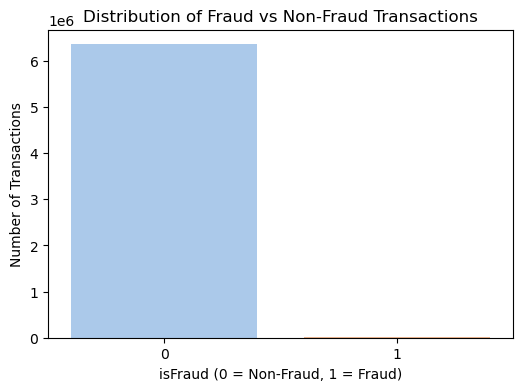

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='isFraud', hue='isFraud', data=data, palette='pastel', legend=False)

plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.xlabel('isFraud (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Number of Transactions')

### Understand behaviour by transaction type

In [9]:
data['type'].value_counts()
data.groupby('type')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
CASH_IN,1399284.0,168920.242004,1.265083e+05,0.04,70510.1825,143427.710,239899.0875,1915267.90
CASH_OUT,2237500.0,176273.964346,1.753297e+05,0.00,72669.6500,147072.185,246539.4775,10000000.00
DEBIT,41432.0,5483.665314,1.331854e+04,0.55,1500.1800,3048.990,5479.1750,569077.51
PAYMENT,2151495.0,13057.604660,1.255645e+04,0.02,4383.8200,9482.190,17561.2200,238637.98
TRANSFER,532909.0,910647.009645,1.879574e+06,2.60,215905.3500,486308.390,974958.0000,92445516.64


([0, 1, 2, 3, 4],
 [Text(0, 0, 'PAYMENT'),
  Text(1, 0, 'TRANSFER'),
  Text(2, 0, 'CASH_OUT'),
  Text(3, 0, 'DEBIT'),
  Text(4, 0, 'CASH_IN')])

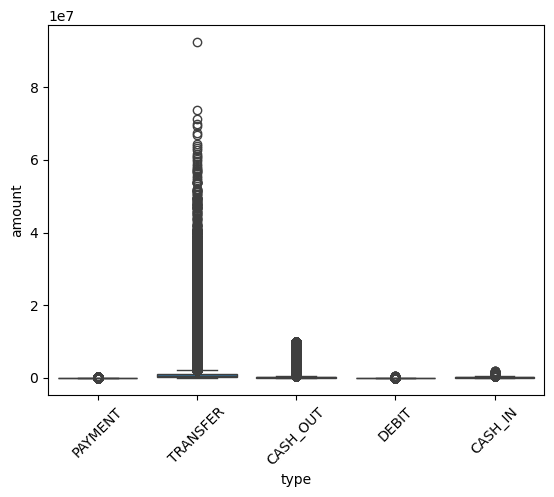

In [10]:
sns.boxplot(x='type', y='amount', data=data)
plt.xticks(rotation=45)

### Relationship between variables

Text(0.5, 1.0, 'Amount vs Fraud')

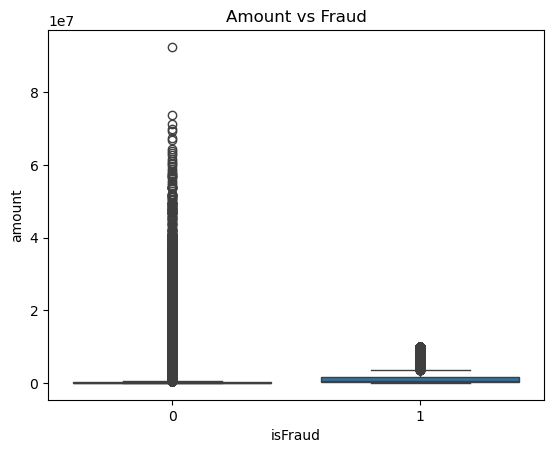

In [11]:
sns.boxplot(x='isFraud', y='amount', data=data)
plt.title('Amount vs Fraud')

# Feature Engineering

In [12]:
## ADD NEW VARIABLES to the dataset
### Balance changes: computing net changes
data['deltaOrig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['deltaDest'] = data['newbalanceDest'] - data['oldbalanceDest']

# add new variables based on amount
type_stats = data.groupby('type')['amount'].agg(['mean','std']).rename(columns={'mean':'amt_mean_by_type','std':'amt_std_by_type'})
data = data.merge(type_stats, on='type', how='left')
data['amount_zscore_by_type'] = (data['amount'] - data['amt_mean_by_type']) / (data['amt_std_by_type'] + 1e-6)

# relative amt features
data['amt_to_balance_ratio'] = data['amount'] / (data['oldbalanceOrg'] + 1e-6)

# customer balance dynamics
data['sender_balance_change_ratio'] = (data['oldbalanceOrg'] - data['newbalanceOrig']) / (data['oldbalanceOrg'] + 1e-6)
data['receiver_balance_change_ratio'] = (data['newbalanceDest'] - data['oldbalanceDest']) / (data['oldbalanceDest'] + 1e-6)

# cumulative transaction features; per acc, compute cumulative sums or counts:
data['cum_amt_sent'] = data.groupby('nameOrig')['amount'].cumsum()
data['cum_tx_count'] = data.groupby('nameOrig').cumcount() + 1
data['avg_amt_so_far'] = data['cum_amt_sent'] / data['cum_tx_count']

## merchant vs customer features
data['isMerchant'] = data['nameDest'].str.startswith('M').astype(int)

# flag-based features
data['is_zero_balance'] = (data['oldbalanceOrg'] == 0).astype(int)
data['is_new_dest'] = (data['oldbalanceDest'] == 0).astype(int)
data['same_balance_flag'] = (data['oldbalanceOrg'] == data['newbalanceOrig']).astype(int)

# sender-receiver relationship features
data['is_repeated_pair'] = data.duplicated(subset=['nameOrig', 'nameDest']).astype(int)

# Extract hour of the day
data['hour'] = data['step'] % 24

# Bin hour into time-of-day categories
def time_bin(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

data['time_bin'] = data['hour'].apply(time_bin)

# Extract day of the week
data['day'] = data['step'] // 24
data['day_of_week'] = data['day'] % 7  # 0 (Mon) to 6 (Sun)
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
data['day_name'] = data['day_of_week'].map(day_map)

## Flag related insights since isFlaggedFraud triggers on transactions > 200,000 LCU: create an indicator for transactions just below 
## below the threshold (e.g. 150,000 - 200,000)
data['near_flag_limit'] = ((data['amount'] > 150000) & (data['amount'] <= 200000)).astype(int)

### Rolling/Temporal Features

In [13]:
data.sort_values(['nameOrig', 'step'], inplace=True)

## Captures when an acc suddenly becomes active
data['tx_count_last_24h'] = data.groupby('nameOrig')['step'].rolling(window=24).count().reset_index(0, drop=True)
data['amt_avg_last_24h'] = data.groupby('nameOrig')['amount'].rolling(window=24).mean().reset_index(0, drop=True)

### Time since last transaction, long inactivity may mean potential fraud
data['time_since_last_tx'] = data.groupby('nameOrig')['step'].diff().fillna(0)

In [14]:
## drop identifiers nameOrig and nameDest as they are high-cardinality identifiers, not meaningful features
data.drop(columns=['nameOrig', 'nameDest'], inplace=True)

### Label Encoding

In [15]:
### Transaction Type and Time Bin Encoding
cat_cols = ['type', 'time_bin']
le = LabelEncoder()
for cat in cat_cols:
    data[cat] = le.fit_transform(data[cat])

In [16]:
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,deltaOrig,...,is_repeated_pair,hour,time_bin,day,day_of_week,day_name,near_flag_limit,tx_count_last_24h,amt_avg_last_24h,time_since_last_tx
3196942,249,1,244486.46,8946.00,0.00,526950.37,771436.84,0,0,8946.00,...,0,9,2,10,3,Thu,0,NaN,NaN,0.0
2798983,217,3,3170.28,58089.00,54918.72,0.00,0.00,0,0,3170.28,...,0,1,3,9,2,Wed,0,NaN,NaN,0.0
1013585,46,3,8424.74,783.00,0.00,0.00,0.00,0,0,783.00,...,0,22,1,1,1,Tue,0,NaN,NaN,0.0
2980283,231,0,261877.19,7596.00,269473.19,1126627.70,864750.51,0,0,-261877.19,...,0,15,0,9,2,Wed,0,NaN,NaN,0.0
1920204,167,0,20528.65,2302074.12,2322602.77,82696.17,62167.52,0,0,-20528.65,...,0,23,1,6,6,Sun,0,NaN,NaN,0.0


### Plot Heatmap

<Axes: >

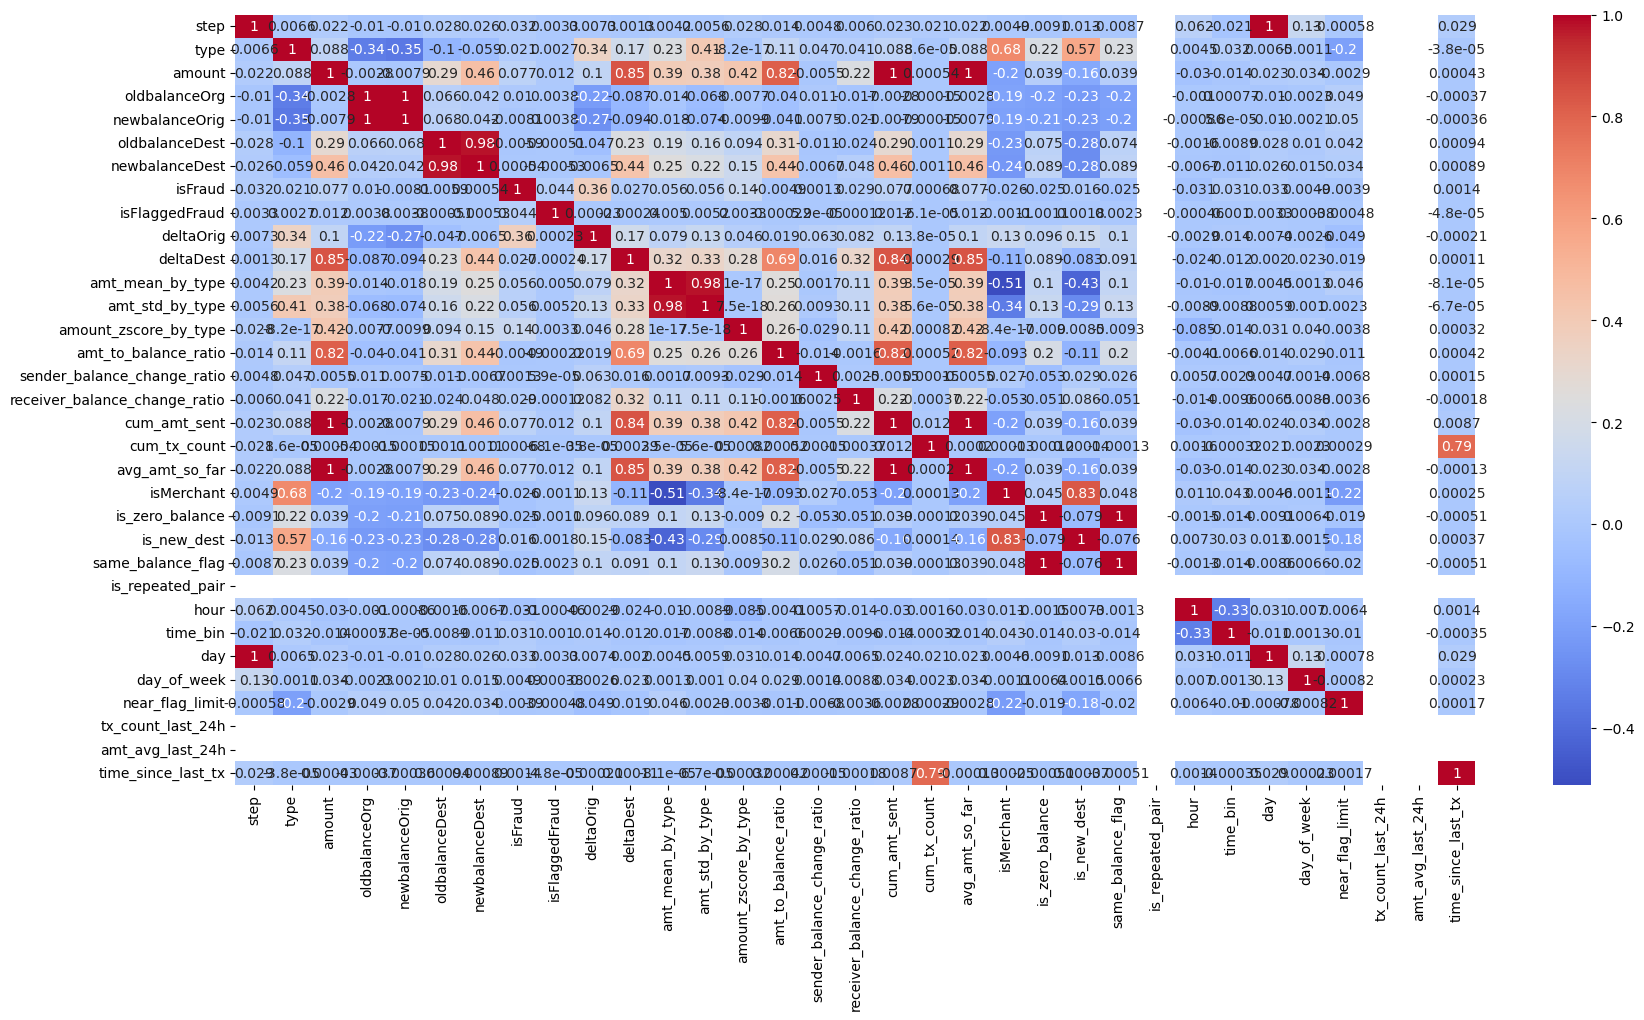

In [18]:
num_cols = data.select_dtypes(include=['number']).columns.tolist()
plt.figure(figsize=(20,10))
sns.heatmap(data[num_cols].corr(), annot=True, cmap='coolwarm')